In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from matplotlib.ticker import FormatStrFormatter

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p, assemble_df, get_exact_p

In [4]:
parc_str = 'schaefer'
parc_scale = 200
edge_weight = 'streamlineCount'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

In [5]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_200_streamlineCount_'

### Setup directory variables

In [6]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [8]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

print(phenos)

metrics = ['str', 'ac']
metrics_label = ['Strength', 'Average Controllability']

algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']
seeds = np.arange(0,100)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']


In [9]:
num_algs = len(algs)
num_metrics = len(metrics)
num_phenos = len(phenos)
num_scores = len(scores)

## Setup plots

In [10]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

## Load data

In [11]:
df_node = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

df_pheno = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'y.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

In [12]:
score = scores[1]; print(score)

rmse


In [13]:
predictiondir = os.path.join(os.environ['PIPELINEDIR'], '3_prediction', 'out', outfile_prefix)
predictiondir

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction/out/schaefer_200_streamlineCount_'

### Load random splits cross-val (with nuis)

In [14]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'
print(indir)

accuracy_mean_nuis = np.zeros((100, len(algs), len(metrics), len(phenos)))
accuracy_std_nuis = np.zeros((100, len(algs), len(metrics), len(phenos)))
y_pred_var = np.zeros((100, len(algs), len(metrics), len(phenos)))

for a, alg in enumerate(algs):
    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):
            accuracy_mean_nuis[:,a,m,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean.txt'))
            accuracy_std_nuis[:,a,m,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_std.txt'))
            y_pred_out_repeats = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'y_pred_out_repeats.txt'))
            y_pred_var[:,a,m,p] = y_pred_out_repeats.var(axis = 0)

if score == 'rmse' or score == 'mae':
    accuracy_mean_nuis = np.abs(accuracy_mean_nuis)
    accuracy_std_nuis = np.abs(accuracy_std_nuis)
                
print(accuracy_mean_nuis.shape)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction/out/schaefer_200_streamlineCount_predict_symptoms_rcv_nuis
(100, 2, 2, 3)


### Load stratified cross-val (with nuis)

In [15]:
indir = predictiondir + 'predict_symptoms_scv_nuis'
print(indir)

scv_accuracy_mean_nuis = np.zeros((len(algs), len(metrics), len(phenos)))
scv_accuracy_std_nuis = np.zeros((len(algs), len(metrics), len(phenos)))

for a, alg in enumerate(algs):
    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):
            scv_accuracy_mean_nuis[a,m,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_mean_nuis.txt'))
            scv_accuracy_std_nuis[a,m,p] = np.loadtxt(os.path.join(indir, alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_std_nuis.txt'))

if score == 'rmse' or score == 'mae':
    scv_accuracy_mean_nuis = np.abs(scv_accuracy_mean_nuis)
    scv_accuracy_std_nuis = np.abs(scv_accuracy_std_nuis)
                
print(scv_accuracy_mean_nuis.shape)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction/out/schaefer_200_streamlineCount_predict_symptoms_scv_nuis
(2, 2, 3)


# Plot results

### Figure S4

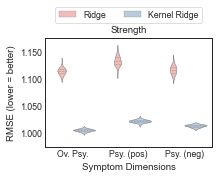

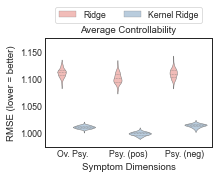

In [16]:
for metric in metrics:
    f, ax = plt.subplots()
    f.set_figwidth(3)
    f.set_figheight(2)

    df = assemble_df(accuracy_mean_nuis, algs, metrics, phenos)
    df = df.loc[df.loc[:,'metric'] == metric,:]
    df.loc[df.loc[:,'alg'] == 'rr','alg'] = 'Ridge'
    df.loc[df.loc[:,'alg'] == 'krr_rbf','alg'] = 'Kernel Ridge'

    sns.violinplot(x = 'pheno', y = 'score', hue = 'alg', data = df, ax = ax, inner = 'quartile', split = False, linewidth = 0.5, palette = 'Pastel1')
    ax.tick_params(pad = -2)

    if metric == 'str': ax.set_title('Strength')
    elif metric == 'ac': ax.set_title('Average Controllability')

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
    ax.set_xticklabels(phenos_short)
    ax.set_xlabel('Symptom Dimensions')
    if score == 'rmse': ax.set_ylabel('RMSE (lower = better)')
    elif score == 'corr': ax.set_ylabel('corr(y_true,y_pred)')

    if score == 'rmse' and parc_scale == 200: ax.set_ylim([0.975,1.175])
    elif score == 'rmse' and parc_scale == 400: ax.set_ylim([0.95,1.45])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    f.savefig(outfile_prefix+'model_selection_'+metric+'.svg', dpi = 300, bbox_inches = 'tight')

In [17]:
a = 1; alg = algs[a]; print(alg)

krr_rbf


### Figure 2

In [18]:
df = assemble_df(accuracy_mean_nuis, algs, metrics, phenos)
df = df.loc[df.loc[:,'alg'] == alg,:]
df = df.loc[df.loc[:,'pheno'] == pheno,:]

In [19]:
stats = pd.DataFrame(index = phenos, columns = ['test_stat', 'pval'])
for pheno in phenos:
    df = assemble_df(accuracy_mean_nuis, algs, metrics, phenos)
    df = df.loc[df.loc[:,'alg'] == alg,:]
    df = df.loc[df.loc[:,'pheno'] == pheno,:]
    
    x = df.loc[df.loc[:,'metric'] == 'str','score']
    y = df.loc[df.loc[:,'metric'] == 'ac','score']
#     my_ttest = sp.stats.ttest_rel(x, y)
#     stats.loc[pheno,'test_stat'] = my_ttest[0]
#     stats.loc[pheno,'pval'] = my_ttest[1]
    stats.loc[pheno,'test_stat'] = np.mean(x)-np.mean(y)
    stats.loc[pheno,'pval'] = get_exact_p(x, y)
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

In [20]:
stats

,test_stat,pval,pval_corr,sig
Overall_Psychopathology,-0.00583821,0.06,0.09,False
Psychosis_Positive,0.0231348,0,0,True
Psychosis_NegativeDisorg,-0.000659901,0.74,0.74,False


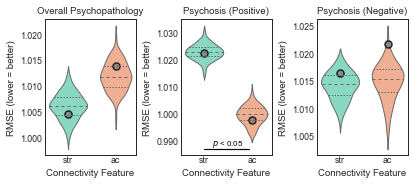

In [21]:
f, ax = plt.subplots(1, len(phenos))
f.set_figwidth(6.5)
f.set_figheight(2.5)

for i, pheno in enumerate(phenos): 
    pheno_label = phenos_label[i]

    df = assemble_df(accuracy_mean_nuis, algs, metrics, phenos)
    df = df.loc[df.loc[:,'alg'] == alg,:]
    df = df.loc[df.loc[:,'pheno'] == pheno,:]

    sns.violinplot(x = 'metric', y = 'score', data = df, ax = ax[i], inner = 'quartile', split = False, palette = cmap, linewidth = 1)
    ax[i].tick_params(pad = -2)

    ax[i].set_title(pheno_label)
    if score == 'rmse': ax[i].set_ylabel('RMSE (lower = better)')
    elif score == 'corr': ax[i].set_ylabel('corr(y_true,y_pred)')

    ax[i].set_xlabel('Connectivity Feature')
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    for tick in ax[i].xaxis.get_majorticklabels():
        tick.set_y(.025)

    if stats.loc[pheno,'sig']:
        y_pos = ax[i].get_ylim()[0]
        ax[i].axhline(y = y_pos-(y_pos*.0005), xmin = 0.25, xmax = 0.75, color = 'black')
        ax[i].text(x = 0.5, y = y_pos-(y_pos*.0005), s =  '$p$ < 0.05', horizontalalignment='center', verticalalignment='bottom', color = 'black', fontsize = 8)

    # add stratified cv score
    ax[i].scatter(x = np.arange(len(metrics)), y = scv_accuracy_mean_nuis[a,:,i], marker = 'o', s = 50, edgecolors = 'black', facecolors = 'gray', alpha=0.8, linewidth = 1.5)

plt.subplots_adjust(wspace=0.5)
        
f.savefig(outfile_prefix+'performance_comparison_'+alg+'.svg', dpi = 300, bbox_inches = 'tight')

### Correlate across scores

In [22]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'
print(indir)
accuracy_mean_nuis_rmse = np.zeros((100, len(algs), len(metrics), len(phenos)))

for a, alg in enumerate(algs):
    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):
            accuracy_mean_nuis_rmse[:,a,m,p] = np.loadtxt(os.path.join(indir, alg + '_rmse_' + metric + '_' + pheno, 'accuracy_mean.txt'))

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction/out/schaefer_200_streamlineCount_predict_symptoms_rcv_nuis


In [23]:
indir = predictiondir + 'predict_symptoms_rcv_nuis'
print(indir)
accuracy_mean_nuis_corr = np.zeros((100, len(algs), len(metrics), len(phenos)))

for a, alg in enumerate(algs):
    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):
            accuracy_mean_nuis_corr[:,a,m,p] = np.loadtxt(os.path.join(indir, alg + '_corr_' + metric + '_' + pheno, 'accuracy_mean.txt'))

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction/out/schaefer_200_streamlineCount_predict_symptoms_rcv_nuis


In [24]:
rmse_corr_corr = np.zeros((len(algs), len(metrics), len(phenos)))

for a, alg in enumerate(algs):
    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):
            rmse_corr_corr[a,m,p] = sp.stats.pearsonr(accuracy_mean_nuis_rmse[:,a,m,p], accuracy_mean_nuis_corr[:,a,m,p])[0]

In [25]:
rmse_corr_corr.mean()

0.8806662073834429

In [26]:
rmse_corr_corr.std()

0.03354351491184851

<AxesSubplot:>

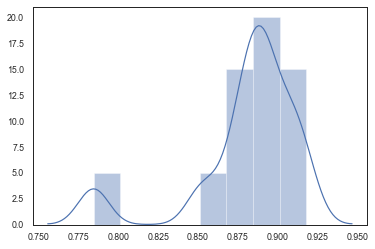

In [27]:
sns.distplot(rmse_corr_corr)

### Load random splits nested cross-val (without nuis)

In [28]:
nested_score_mean = np.load(os.path.join(predictiondir+'predict_symptoms_ncv', 'nested_score_mean.npy'))
print(nested_score_mean.shape)

if score == 'corr':
    nested_score_mean = nested_score_mean[:,:,0,:,:]
elif score == 'rmse':
    nested_score_mean = nested_score_mean[:,:,1,:,:]
    nested_score_mean = np.abs(nested_score_mean)

print(nested_score_mean.shape)

(100, 2, 2, 2, 3)
(100, 2, 2, 3)


### Figure S5

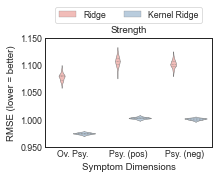

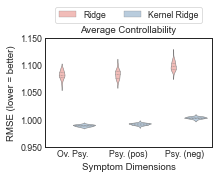

In [29]:
for metric in metrics:
    f, ax = plt.subplots()
    f.set_figwidth(3)
    f.set_figheight(2)

    df = assemble_df(nested_score_mean, algs, metrics, phenos)
    df = df.loc[df.loc[:,'metric'] == metric,:]
    df.loc[df.loc[:,'alg'] == 'rr','alg'] = 'Ridge'
    df.loc[df.loc[:,'alg'] == 'krr_rbf','alg'] = 'Kernel Ridge'

    sns.violinplot(x = 'pheno', y = 'score', hue = 'alg', data = df, ax = ax, inner = 'quartile', split = False, linewidth = 0.5, palette = 'Pastel1')
#     if score == 'rmse': ax.axhline(y = 1, color = 'black', linestyle = ':')
    ax.tick_params(pad = -2)

    if metric == 'str': ax.set_title('Strength')
    elif metric == 'ac': ax.set_title('Average Controllability')

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
    ax.set_xticklabels(phenos_short)
    ax.set_xlabel('Symptom Dimensions')
    if score == 'rmse': ax.set_ylabel('RMSE (lower = better)')
    elif score == 'corr': ax.set_ylabel('corr(y_true,y_pred)')

    if score == 'rmse' and parc_scale == 200: ax.set_ylim([0.95,1.15])
    elif score == 'rmse' and parc_scale == 400: ax.set_ylim([0.95,1.4])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    f.savefig(outfile_prefix+'model_selection_2_'+metric+'.svg', dpi = 300, bbox_inches = 'tight')

### Figure S6

In [30]:
stats = pd.DataFrame(index = phenos, columns = ['test_stat', 'pval'])
for pheno in phenos:
    df = assemble_df(nested_score_mean, algs, metrics, phenos)
    df = df.loc[df.loc[:,'alg'] == alg,:]
    df = df.loc[df.loc[:,'pheno'] == pheno,:]
    
    x = df.loc[df.loc[:,'metric'] == 'str','score']
    y = df.loc[df.loc[:,'metric'] == 'ac','score']
#     my_ttest = sp.stats.ttest_rel(x, y)
#     stats.loc[pheno,'test_stat'] = my_ttest[0]
#     stats.loc[pheno,'pval'] = my_ttest[1]
    stats.loc[pheno,'test_stat'] = np.mean(x)-np.mean(y)
    stats.loc[pheno,'pval'] = get_exact_p(x, y)
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

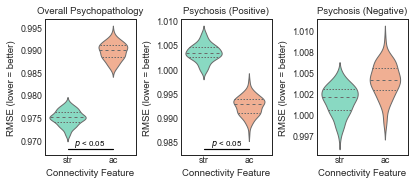

In [31]:
f, ax = plt.subplots(1, len(phenos))
f.set_figwidth(6.5)
f.set_figheight(2.5)

for i, pheno in enumerate(phenos): 
    pheno_label = phenos_label[i]

    df = assemble_df(nested_score_mean, algs, metrics, phenos)
    df = df.loc[df.loc[:,'alg'] == alg,:]
    df = df.loc[df.loc[:,'pheno'] == pheno,:]

    sns.violinplot(x = 'metric', y = 'score', data = df, ax = ax[i], inner = 'quartile', split = False, palette = cmap, linewidth = 1)
    ax[i].tick_params(pad = -2)

    ax[i].set_title(pheno_label)
    if score == 'rmse': ax[i].set_ylabel('RMSE (lower = better)')
    elif score == 'corr': ax[i].set_ylabel('corr(y_true,y_pred)')

    ax[i].set_xlabel('Connectivity Feature')
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    for tick in ax[i].xaxis.get_majorticklabels():
        tick.set_y(.025)

    if stats.loc[pheno,'sig']:
        y_pos = ax[i].get_ylim()[0]
        ax[i].axhline(y = y_pos-(y_pos*.0005), xmin = 0.25, xmax = 0.75, color = 'black')
        ax[i].text(x = 0.5, y = y_pos-(y_pos*.0005), s =  '$p$ < 0.05', horizontalalignment='center', verticalalignment='bottom', color = 'black', fontsize = 8)

plt.subplots_adjust(wspace=0.5)
        
f.savefig(outfile_prefix+'performance_comparison_2_'+alg+'.svg', dpi = 300, bbox_inches = 'tight')

### Correlate across scores

In [32]:
nested_score_mean = np.load(os.path.join(predictiondir+'predict_symptoms_ncv', 'nested_score_mean.npy'))
print(nested_score_mean.shape)

nested_score_mean_corr = nested_score_mean[:,:,0,:,:]
nested_score_mean_rmse = nested_score_mean[:,:,1,:,:]

(100, 2, 2, 2, 3)


In [33]:
rmse_corr_corr = np.zeros((len(algs), len(metrics), len(phenos)))

for a, alg in enumerate(algs):
    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):
            rmse_corr_corr[a,m,p] = sp.stats.pearsonr(nested_score_mean_rmse[:,a,m,p], nested_score_mean_corr[:,a,m,p])[0]

In [34]:
rmse_corr_corr.mean()

0.7879058467937993

In [35]:
rmse_corr_corr.std()

0.10464841246967499

<AxesSubplot:>

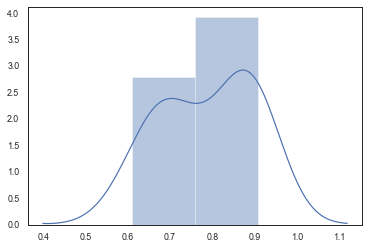

In [36]:
sns.distplot(rmse_corr_corr)